# 03: Naive Bayes classifiers

In [121]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

import mylib as my

## Multinomial naive Bayes classifier
Given an unseen example $\boldsymbol{x}$, we want to predict its corresponding $y$ from a set of possible classes $y_1, y_2, \dots$. We can do so by picking the $y$ such that:
$$ y = \operatorname*{argmax}_{i}\ \ P(y_i | \boldsymbol{x})$$

We can calculate $P(y_i | \boldsymbol{x})$ using the formula:
$$ P(y_i | \boldsymbol{x}) = \alpha\ P(y_i) P(\boldsymbol{x} | y_i) $$

where $\alpha$ is a normalizing factor and $P(y_i)$ is the prior probability which can be estimated from the training dataset.

What makes **naive Bayes** naive, the strong assumption that the features $x_1, x_2, x_3, \cdots, x_m$ are independent from one another. Such an assumption allows us to write:

$$P(\boldsymbol{x} | y_i) = P(x_1, x_2, x_3, \cdots, x_m| y_i) = P(x_1 | y_i)P(x_2 | y_i)P(x_3 | y_i)\cdots P(x_m | y_i)$$
 
The $P(x_j | y_i)$ is the likelihood of $x_j$ given the class $y_i$, which can be estimated from the training set as well.

In [122]:
class NaiveBayesClassifier:
    def fit(self, dataset):
        self.ds = dataset
        """
        Sets things up for classification by preprocessing the training dataset
        and calculating the priors
        """
        # target possibile outcomes
        self.labels = self.ds.examples.iloc[:, -1].unique()
        # probability for each target ^
        self.prior = self.ds.examples.iloc[:, -1].value_counts() / self.ds.examples.iloc[:, -1].count()
    
    def predict(self, unseen):
        """
        Returns the most probable label (or class) for each unseen input
        """
        if unseen.ndim == 1:
            # series/dict of feature : val for unseen; e.g., {deadline : ne, party: 'N', lazy : 'Y'}
            x = pd.Series(unseen, index= self.ds.features)
            # Y probabilities for each possible outcome (zeros for now)
            prob = pd.Series(0.0, index= self.labels)
            # for each possible target outcome
            for lbl in self.labels:
                # all the data we have with matching this target outcome (lbl)
                df_per_lbl = self.ds.examples.where(self.ds.examples.iloc[:, -1] == lbl).dropna()

                likelihood = 1
                # for each col in X
                for f in self.ds.features:
                    # get probability of all possible outcomes for this col
                    prob_per_lbl = df_per_lbl[f].value_counts() / df_per_lbl[f].count()
                    # multiply likelihood by the ratio of times this lbl was as is for target outcome
                    # if there was never a time this feature equaled this value for target, * 0
                    likelihood *= prob_per_lbl[x[f]] if x[f] in prob_per_lbl else 0

                # now the likelihood equals the product of ratios of our values for each feature
                
                # prob for this outcome is likelihood * previous prob for outcome according to seen data
                prob[lbl] = likelihood * self.prior[lbl]
                
            # return the probability label that has the highest value/pair/likelihood... whatever
            return prob.idxmax()
        
        else:
            return np.array([self.predict(ex) for ex in unseen])

## An example
Let's test this using the example from the textbook:

In [123]:
ds = my.DataSet(pd.DataFrame({
    'deadline': ['ur', 'ur', 'ne', 'no', 'no', 'no', 'ne', 'ne', 'ne', 'ur'],
    'party': ['Y', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'N'],
    'lazy': ['Y', 'Y', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'N'],
    'activity': ['Pa', 'St', 'Pa', 'Pa', 'Pu', 'Pa', 'St', 'tv', 'Pa', 'St']
}), y=True)

In [124]:
ds.examples

,deadline,party,lazy,y
0,ur,Y,Y,Pa
1,ur,N,Y,St
2,ne,Y,Y,Pa
3,no,Y,N,Pa
4,no,N,Y,Pu
5,no,Y,N,Pa
6,ne,N,N,St
7,ne,N,Y,tv
8,ne,Y,Y,Pa
9,ur,N,N,St


In [125]:
nb = NaiveBayesClassifier()
nb.fit(ds)
print(nb.predict(np.array(['ne', 'N', 'Y'])))

tv


In [126]:
cm = my.confusion_matrix(ds.target, nb.predict(ds.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

[[5 0 0 0]
 [0 1 0 0]
 [0 0 3 0]
 [0 0 0 1]]
Training accuracy:  1.0


## Gaussian naive Bayes classifier
The previous classifier does not work with continuous-valued features. For these features, we estimate the prior probabilities like before based on the training set. For the likelihood (conditional) probabilities, we make the assumption that they follow the normal (or Gaussian) distribution. Then we use training set to estimate the $\mu$ and $\sigma$ parameters of these Gaussian distributions.

In [127]:
class GaussianNaiveBayesClassifier:
    def fit(self, dataset):
        """
        Sets things up for classification by preprocessing the training dataset
        and calculating the priors
        """
        self.ds = dataset
        self.labels = self.ds.examples.iloc[:, -1].unique()
        self.label_column = self.ds.examples.columns[-1]
        self.prior = self.ds.examples.iloc[:, -1].value_counts() / self.ds.examples.iloc[:, -1].count()
        self.mu = self.ds.examples.groupby(self.label_column).mean()
        self.std = self.ds.examples.groupby(self.label_column).std()
    
    def predict(self, unseen):
        """
        Returns the most probable label (or class) for each unseen input
        """
        if unseen.ndim == 1:
            x = pd.Series(unseen, index= self.ds.features)
            prob = pd.Series(0.0, index= self.labels)
            for lbl in self.labels:
                likelihood = 1
                for f in self.ds.features:
                    likelihood *= st.norm.pdf(x[f], loc= self.mu.at[lbl, f], scale=self.std.at[lbl, f])

                prob[lbl] = likelihood * self.prior[lbl]
                
            return prob.idxmax()
        
        else:
            return np.array([self.predict(ex) for ex in unseen])

In [128]:
class GaussianNaiveBayesClassifier_iter:
    def fit(self, dataset):
        """
        Sets things up for classification by preprocessing the training dataset
        and calculating the priors
        """
        self.ds = dataset
        self.labels = self.ds.examples.iloc[:, -1].unique()
        self.label_column = self.ds.examples.columns[-1]
        self.prior = self.ds.examples.iloc[:, -1].value_counts() / self.ds.examples.iloc[:, -1].count()
        self.mu = self.ds.examples.groupby(self.label_column).mean()
        self.std = self.ds.examples.groupby(self.label_column).std()
    
    def predict(self, unseen):
        """
        Returns the most probable label (or class) for each unseen input
        """
        probs = []
        deriv = False
        if unseen.ndim == 1:
            unseen = [unseen]
            deriv = True
        for u in unseen:
            x = pd.Series(u, index= self.ds.features)
            prob = pd.Series(0.0, index= self.labels)
            for lbl in self.labels:
                likelihood = 1
                for f in self.ds.features:
                    likelihood *= st.norm.pdf(x[f], loc= self.mu.at[lbl, f], scale=self.std.at[lbl, f])

                prob[lbl] = likelihood * self.prior[lbl]
                
            probs.append(prob.idxmax())
        
        if deriv:
            return np.array(probs[0])
        else:
            return np.array(probs)

# An example

In [129]:
basis = np.array([[3, 14],[4, 4],[10, 9]])
a_ = np.concatenate((
        basis[0,0] + np.random.normal(loc=1, scale=2.5, size=(50, 1)), 
        basis[0, 1] + np.random.normal(loc=1, scale=2.6, size=(50, 1)), 
        np.full(50, -1).reshape(50,1)), axis= 1)

b_ = np.concatenate((
        basis[1,0] + np.random.normal(loc=.8, scale=2.5, size=(50, 1)), 
        basis[1, 1] + np.random.normal(loc=.8, scale=2.4, size=(50, 1)), 
        np.full(50, 0).reshape(50,1)), axis= 1)

c_ = np.concatenate((
        basis[2,0] + np.random.normal(loc=.5, scale=2.5, size=(50, 1)), 
        basis[2, 1] + np.random.normal(loc=.5, scale=2.6, size=(50, 1)), 
        np.full(50, 1).reshape(50,1)), axis= 1)
data = pd.DataFrame(np.concatenate([a_, b_, c_], axis=0), columns=['x1', 'x2', 't'])
ds = my.DataSet(data, y=True)
ds

            x1         x2    y
0    -1.590631  15.582340 -1.0
1     2.821689  12.383122 -1.0
2     7.431363  14.963753 -1.0
3     1.328117  11.589126 -1.0
4     3.869668  16.869159 -1.0
..         ...        ...  ...
145  12.303105   8.345599  1.0
146   9.565255  11.558660  1.0
147  13.326385  10.945592  1.0
148  13.031585  10.167630  1.0
149  11.840056   6.886273  1.0

[150 rows x 3 columns]

In [130]:
gnb = GaussianNaiveBayesClassifier()
gnb.fit(ds)
cm = my.confusion_matrix(ds.target, gnb.predict(ds.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667


C:\Users\Mike\Documents\GitHub\cs6600\cs6600-notebooks\mylib\decision_regions.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, Z, cmap=cmap_light)


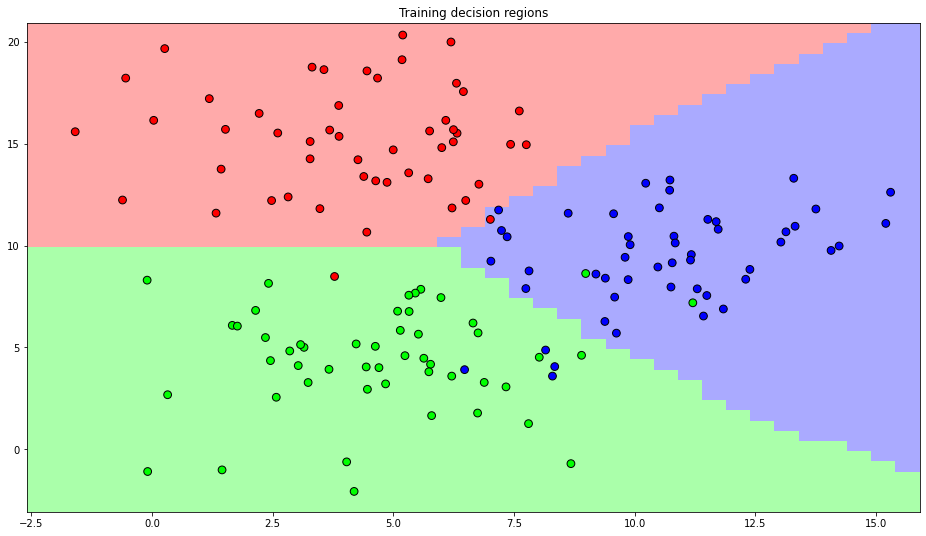

In [131]:
my.plot_decision_regions(ds.inputs, ds.target, gnb, resolution=0.5, title="Training decision regions")

## CHALLENGE
Re-implement the above `GaussianNaiveBayesClassifier` so as to make the `predict` method non-recursive. 
* Test your implementation and plot the decision regions of your training set.
* Benchmark your implementation using the `%%timeit` magic command against the above recursive implementation. Report any performance gain/loss you see.


### The recursive method

In [132]:
%%timeit
gnb = GaussianNaiveBayesClassifier()
gnb.fit(ds)
cm = my.confusion_matrix(ds.target, gnb.predict(ds.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
530 ms ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### The iterative method

In [133]:
%%timeit
gnbi = GaussianNaiveBayesClassifier_iter()
gnbi.fit(ds)
cm = my.confusion_matrix(ds.target, gnbi.predict(ds.inputs))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Training accuracy: ', accuracy)

[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
[[48  1  1]
 [ 0 48  2]
 [ 0  4 46]]
Training accuracy:  0.9466666666666667
548 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


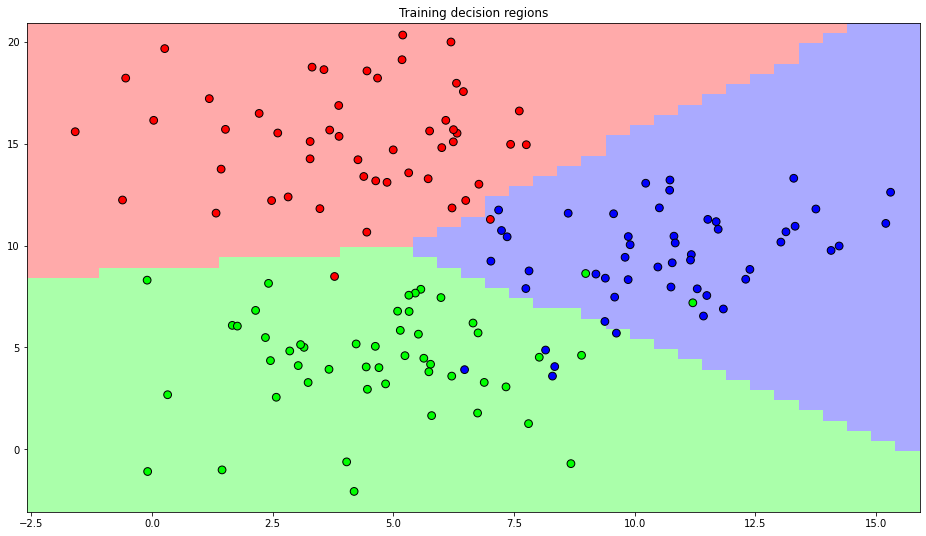

In [134]:
my.plot_decision_regions(ds.inputs, ds.target, gnbi, resolution=0.5, title="Training decision regions")

### Results
My iterative method of the GaussianNaiveBayesClassifier ended up being 18 ms slower than the recursive method. This is probably because of some overhead I had to add to deal with the iterative option. 

Also, it may not have improved efficiency because the only recursive uses of the former method was to split any n-dimensional lists into 1-dimensional lists in order to be properly fed to the prediction algorithm. This isn't a crucial part of the algorithm. In fact, it's a somewhat trivial and data-cleaning task. 